<a href="https://colab.research.google.com/github/rahimova-zulya/myprojects/blob/main/Bank_Product_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Проект: Рекомендательная система банковских продуктов

### Цель
Построить модель, предсказывающую вероятность отклика клиента на банковское предложение; использовать её как основу для простой рекомендательной системы.

### Использовано:
- Python, Pandas, Scikit-learn, RandomForest
- Bank Marketing Dataset (UCI)

### Метрики:
- Accuracy, Precision, Recall, ROC-AUC

### Идея:
Простейшая рекомендательная система, которую можно расширить на прод-уровне, добавив поведенческие и временные данные.


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
from sklearn.preprocessing import LabelEncoder

cat_columns = df.select_dtypes(include='object').columns.tolist()
cat_columns.remove('y')  # целевая переменная

le_dict = {}
for col in cat_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [5]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})


In [6]:
## Разделение на train/test

from sklearn.model_selection import train_test_split

X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
## Random forest

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7952
           1       0.64      0.41      0.50      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.69      0.72      9043
weighted avg       0.89      0.90      0.89      9043

ROC AUC: 0.9245165654790337


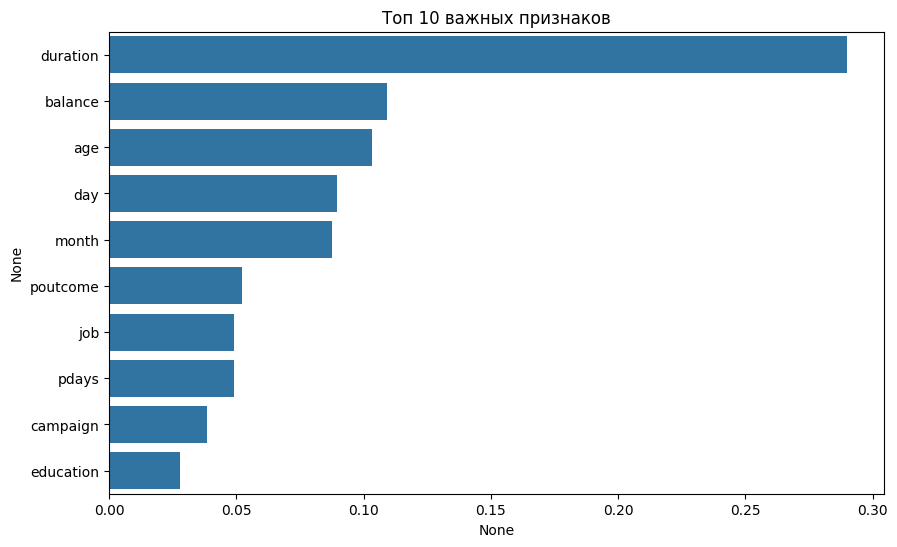

In [10]:
## TOP

import matplotlib.pyplot as plt
import seaborn as sns

feat_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance[:10], y=feat_importance.index[:10])
plt.title('Топ 10 важных признаков')
plt.show()

In [14]:
def recommend_proba(user_dict):
    user_df = pd.DataFrame([user_dict])
    for col in cat_columns:
        user_df[col] = le_dict[col].transform(user_df[col])
    prob = model.predict_proba(user_df)[0][1]
    return f'Вероятность покупки продукта: {prob:.2f}'

In [17]:
!pip install gradio

import gradio as gr

def predict_gradio(age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome):
    input_dict = {
        'age': age,
        'job': [job],
        'marital': [marital],
        'education': [education],
        'default': [default],
        'balance': balance,
        'housing': [housing],
        'loan': [loan],
        'contact': [contact],
        'day': day,
        'month': [month],
        'duration': duration,
        'campaign': campaign,
        'pdays': pdays,
        'previous': previous,
        'poutcome': [poutcome]
    }
    return recommend_proba(input_dict)

gr.Interface(
    fn=predict_gradio,
    inputs=[
        gr.Number(label='Age'),
        gr.Textbox(label='Job'),
        gr.Textbox(label='Marital'),
        gr.Textbox(label='Education'),
        gr.Textbox(label='Default'),
        gr.Number(label='Balance'),
        gr.Textbox(label='Housing'),
        gr.Textbox(label='Loan'),
        gr.Textbox(label='Contact'),
        gr.Number(label='Day'),
        gr.Textbox(label='Month'),
        gr.Number(label='Duration'),
        gr.Number(label='Campaign'),
        gr.Number(label='Pdays'),
        gr.Number(label='Previous'),
        gr.Textbox(label='Poutcome'),
    ],
    outputs='text',
    live=True
).launch()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://16569cd787b8bfc1b3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory 

## Выводы

- Модель предсказывает вероятность того, что клиент заинтересуется продуктом.
- Наиболее важные признаки: возраст, баланс, тип контакта, наличие кредита.
- Метрика ROC AUC показывает 0.925. Это говорит о высокой способности модели различать откликнувшихся и не откликнувшихся на предложение клиентов.